# Identifying which food distribution sector produces the most food waste and modelling the loss percentage

This project hopes to tabulate and model how much Food Loss and Waste (FLW) is produced throughout the Food Supply Chain (FSC). Data collected will be used to train models to predict food loss based on year, country, commodity, and FSC stage. The results will show at which stages of the FSC produces the most and least amount of waste.

## Importing Libraries

In [1]:
# For data visualisation and manipulation
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import re

# configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

# For preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# For Modelling
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm
import xgboost

## Loading the Dataset

The data used in this project came from [FAO's Food Loss and Waste Database](https://www.fao.org/platform-food-loss-waste/flw-data/en/). It is a database that shows how much food was wasted and in what stage it was wasted.

In [2]:
# read the data from the csv into the dataframe
df = pd.read_csv("data.csv", header=0)

# print the column names
print('---ORIGINAL DATASET---\n')
print('COLUMNS')
print(df.columns)
print()

# print the shape
print('SHAPE')
print(df.shape)

# show the first 5 rows of the dataframe
df.head()

---ORIGINAL DATASET---

COLUMNS
Index(['m49_code', 'country', 'region', 'cpc_code', 'commodity', 'year',
       'loss_percentage', 'loss_percentage_original', 'loss_quantity',
       'activity', 'food_supply_stage', 'treatment', 'cause_of_loss',
       'sample_size', 'method_data_collection', 'reference', 'url', 'notes'],
      dtype='object')

SHAPE
(32580, 18)


,m49_code,country,region,cpc_code,commodity,year,loss_percentage,loss_percentage_original,loss_quantity,activity,food_supply_stage,treatment,cause_of_loss,sample_size,method_data_collection,reference,url,notes
0,104,Myanmar,NaN,0142,"Groundnuts, excluding shelled",2009,5.22,5.22%,68100,NaN,Whole supply chain,NaN,NaN,NaN,FAO's annual Agriculture Production Questionna...,FAO Sources,NaN,NaN
1,104,Myanmar,NaN,0142,"Groundnuts, excluding shelled",2008,5.43,5.43%,65240,NaN,Whole supply chain,NaN,NaN,NaN,FAO's annual Agriculture Production Questionna...,FAO Sources,NaN,NaN
2,104,Myanmar,NaN,0142,"Groundnuts, excluding shelled",2007,5.61,5.61%,61080,NaN,Whole supply chain,NaN,NaN,NaN,FAO's annual Agriculture Production Questionna...,FAO Sources,NaN,NaN
3,104,Myanmar,NaN,0142,"Groundnuts, excluding shelled",2006,5.40,5.4%,55270,NaN,Whole supply chain,NaN,NaN,NaN,FAO's annual Agriculture Production Questionna...,FAO Sources,NaN,NaN
4,104,Myanmar,NaN,0142,"Groundnuts, excluding shelled",2005,5.00,5%,51970,NaN,Whole supply chain,NaN,NaN,NaN,FAO's annual Agriculture Production Questionna...,FAO Sources,NaN,NaN


## Preprocessing
This section is divided further into
- Data Representation
- Data Cleaning
- Data Transformation
    - Encoding
    - Scaling
- Creating Train and Test Data

#### Data Representation
Extract the necessary columns for this project (year, country, commodity, loss_percentage, and food_supply_stage)

In [3]:
# extract necessary columns
df = df[["year", "country","commodity", "food_supply_stage", "loss_percentage"]]
df.head()

,year,country,commodity,food_supply_stage,loss_percentage
0,2009,Myanmar,"Groundnuts, excluding shelled",Whole supply chain,5.22
1,2008,Myanmar,"Groundnuts, excluding shelled",Whole supply chain,5.43
2,2007,Myanmar,"Groundnuts, excluding shelled",Whole supply chain,5.61
3,2006,Myanmar,"Groundnuts, excluding shelled",Whole supply chain,5.40
4,2005,Myanmar,"Groundnuts, excluding shelled",Whole supply chain,5.00


#### Removing column values with low cardinality
Let us check the number of unique values for each independent column

<AxesSubplot:xlabel='feature', ylabel='nunique'>

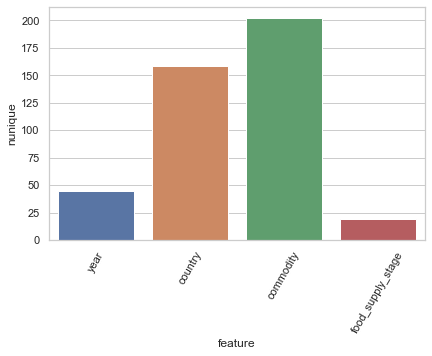

In [4]:
nu = df[["year", "country","commodity", "food_supply_stage"]].nunique().reset_index()
nu.columns = ['feature','nunique']
ax = sns.barplot(x='feature', y='nunique', data=nu)
plt.xticks(rotation=60)
ax
# Notice that the unique values for commodity and country are much higher compared to year and food_supply_stage
# To address this, we will filter countries and commodities based on how much data we have for them 
# (removing those with less data available)

Let us check the frequency of each unique value in commodity

<AxesSubplot:xlabel='commodity', ylabel='count'>

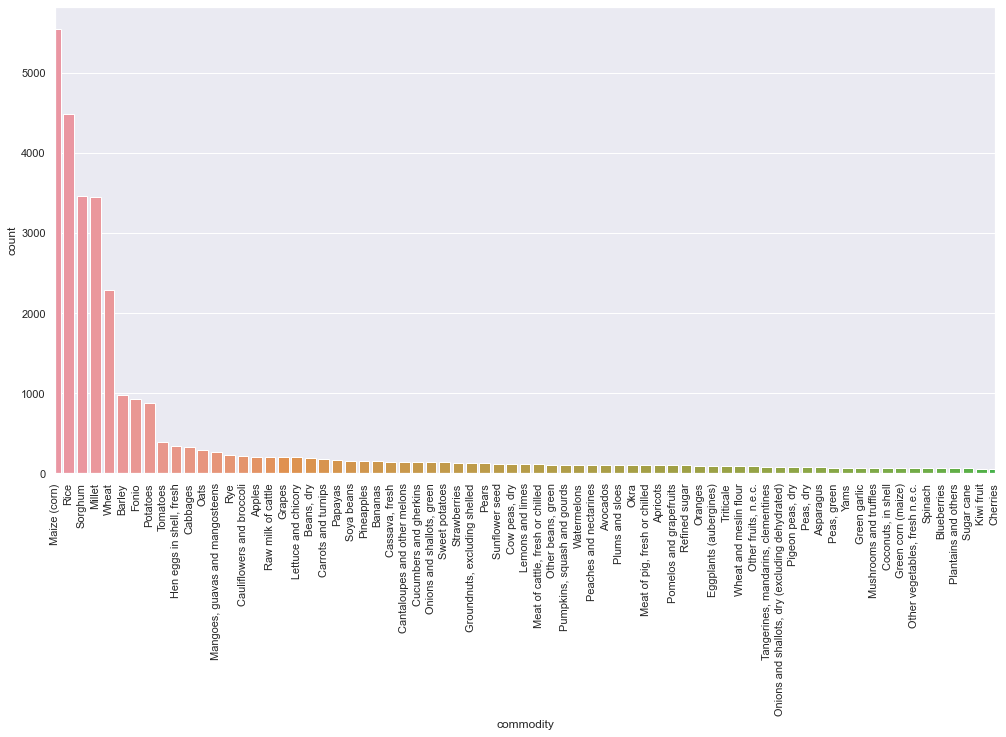

In [5]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.countplot(x="commodity",data=df, order = df['commodity'].value_counts().index)
plt.xticks(rotation= 'vertical')
ax.set_xlim(0, 70) #we only display the top 70 commodities since displaying all commodity will make the plot unreadable
ax
# We see that there is a huge gap between the cardinalities/frequency of the commodities

We will only keep the commodities with the at least 200 frequencies since they will provide more accurate results for there are more available data on them

In [6]:
# print total rows in the dataframe 
print("Length of dataframe before:", len(df))

df = df.groupby('commodity').filter(lambda x : len(x)>200)

# print total rows left in the dataframe 
print("Length of dataframe after removing low cardinality commodities:", len(df))

# Note that the remaining commodities is still almost 80% of the total data

Length of dataframe before: 32580
Length of dataframe after removing low cardinality commodities: 24870


We will do the same process for the country column. Let us check the frequency of each unique value in the column.

<AxesSubplot:xlabel='country', ylabel='count'>

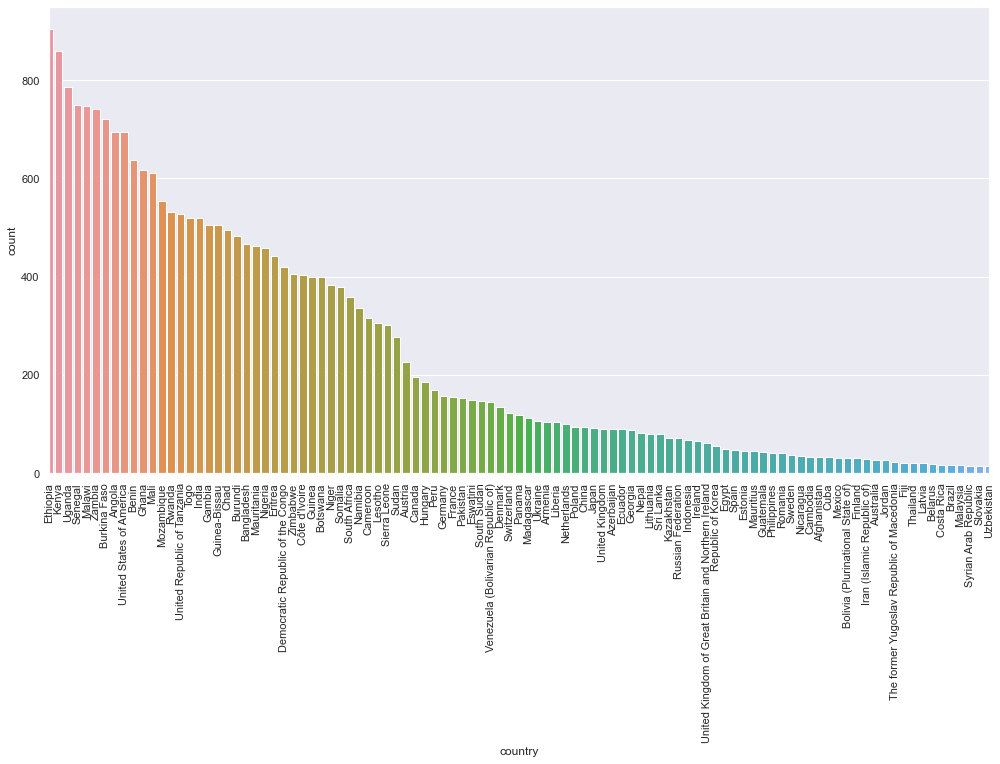

In [7]:
ax = sns.countplot(x="country",data=df, order = df['country'].value_counts().index)
plt.xticks(rotation= 'vertical')
ax.set_xlim(0, 100)
ax
# We see that the data from each country is much more disributed compared to the commodity

Removing countries with the less than 200 cardinality 

In [8]:
print("Length of dataframe before:", len(df))
df = df.groupby('country').filter(lambda x : len(x)>200)
print("Length of dataframe after:", len(df))

Length of dataframe before: 24870
Length of dataframe after: 20125


#### Dealing with outliers

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='loss_percentage'>

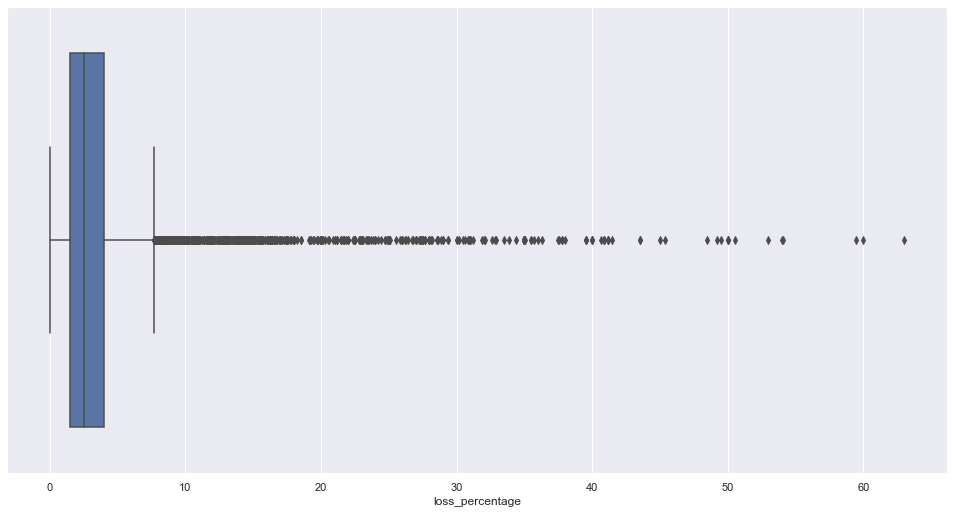

In [9]:
sns.boxplot(df['loss_percentage'])

In [10]:
print("Before removing outliers: ", df.shape)
Q1= df['loss_percentage'].quantile(0.25)
Q3 = df['loss_percentage'].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR
df = df[(df['loss_percentage'] > lower) & (df['loss_percentage'] < upper)]
print("After removing outliers: ", df.shape)

Before removing outliers:  (20125, 5)
After removing outliers:  (19021, 5)


## Exploratory Data Analysis
Before proceeding to the next steps of Data Cleaning, let us explore the data first

<AxesSubplot:xlabel='food_supply_stage', ylabel='loss_percentage'>

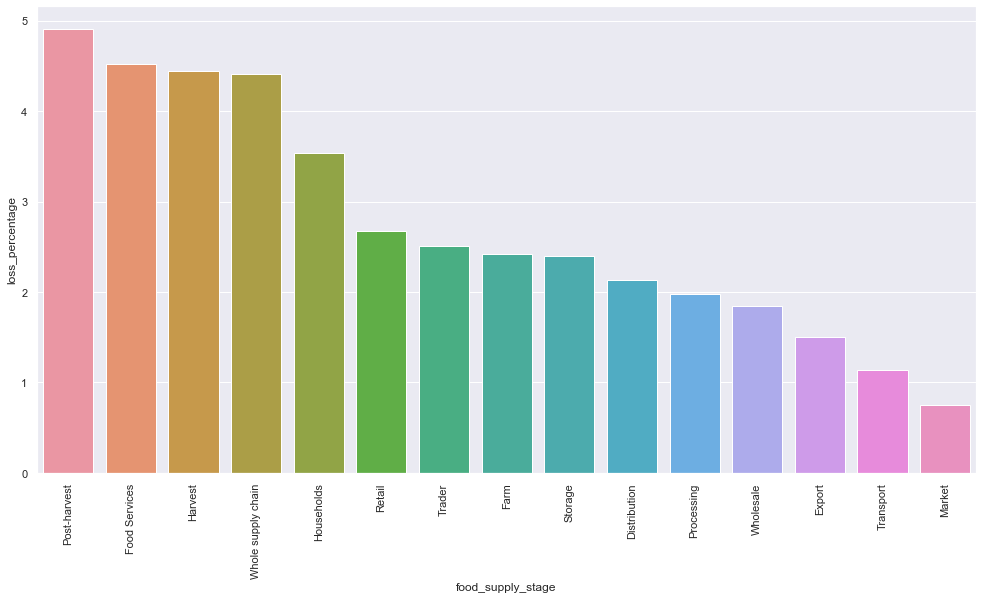

In [11]:
# Showing point estimate of the loss percentage in each food supply stage
result = df.groupby(["food_supply_stage"])['loss_percentage'].aggregate(np.mean).reset_index().sort_values('loss_percentage',
                                                                                                          ascending =False)
ax = sns.barplot(x="food_supply_stage", y="loss_percentage", data=df,  order=result["food_supply_stage"], ci =None )
plt.xticks(rotation='vertical')
ax

We can observe that the loss percentage is highest on Post_Harvest

<AxesSubplot:xlabel='year', ylabel='loss_percentage'>

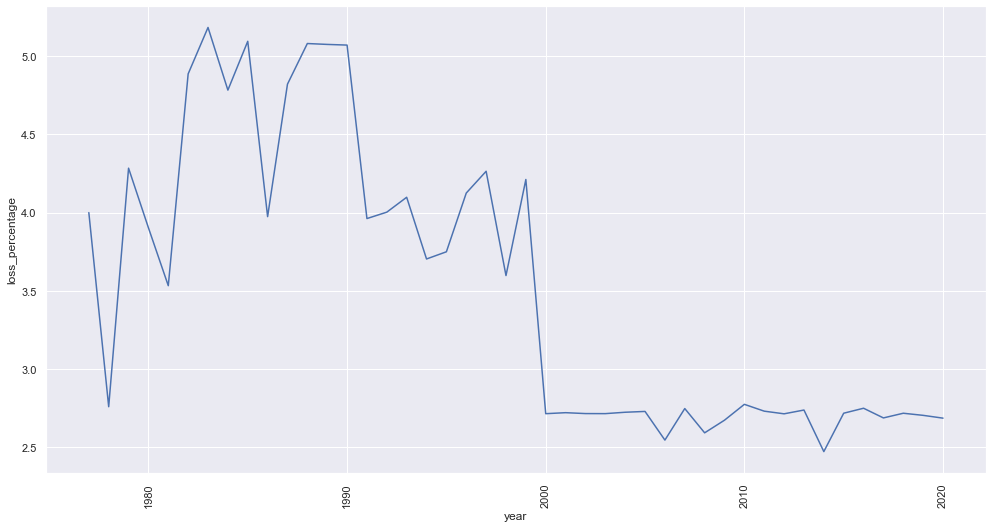

In [12]:
# Showing the  point estimate of the loss percentage of each year
ax = sns.lineplot(x="year", y="loss_percentage", data=df, ci = None)
plt.xticks(rotation='vertical')
ax

The bar plot shows that there has been a significant decrease of the loss percentage starting from the year 2000

<AxesSubplot:xlabel='country', ylabel='loss_percentage'>

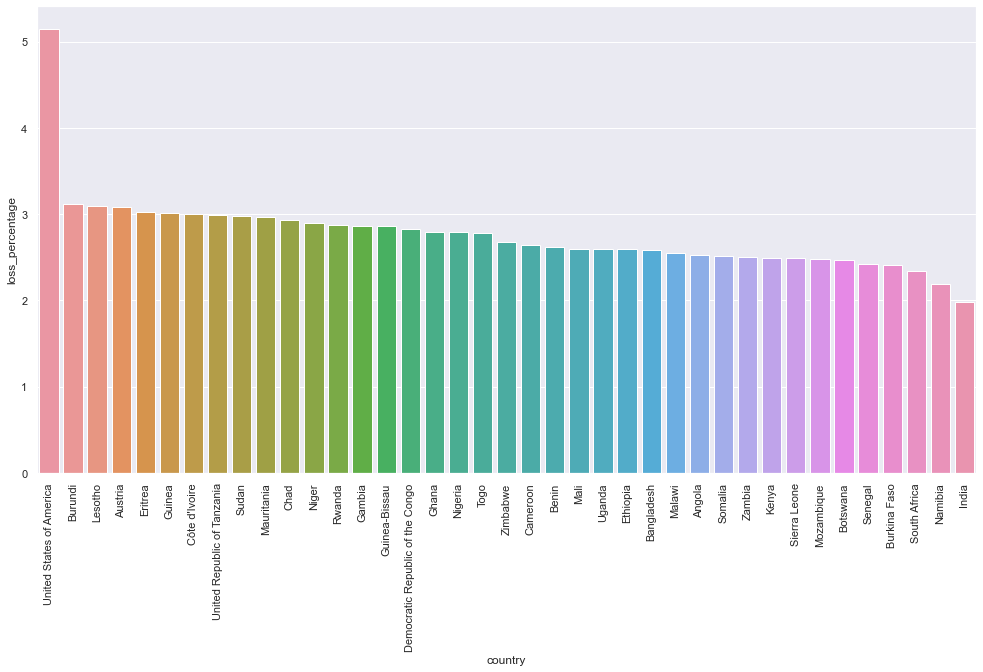

In [13]:
# Showing the  point estimate of the loss percentage of each country
result = df.groupby(["country"])['loss_percentage'].aggregate(np.mean).reset_index().sort_values('loss_percentage',                                                                                               
                                                                                                 ascending =False)
ax = sns.barplot(x="country", y="loss_percentage", data= df, order=result["country"], ci =None)
plt.xticks(rotation='vertical')
ax

We can observe that the loss percentage is highest on USA

<AxesSubplot:xlabel='commodity', ylabel='loss_percentage'>

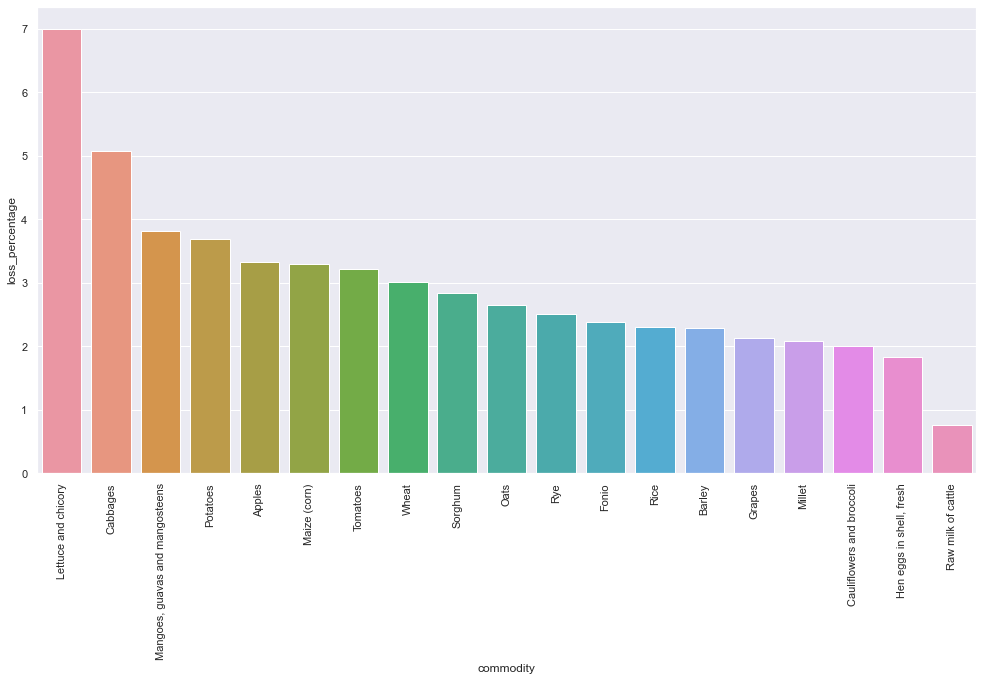

In [14]:
# Showing the  point estimate of the loss percentage of each commodity
result = df.groupby(["commodity"])['loss_percentage'].aggregate(np.mean).reset_index().sort_values('loss_percentage',   
                                                                                                   ascending =False)
ax = sns.barplot(x="commodity", y="loss_percentage", data= df, order=result["commodity"], ci =None)
plt.xticks(rotation='vertical')
ax

We can observe that the loss percentage is highest for Lettuce and chicory

Text(0.5, 1.0, 'Breakdown of Loss percentage per commodity and Food Supply Stage of the USA')

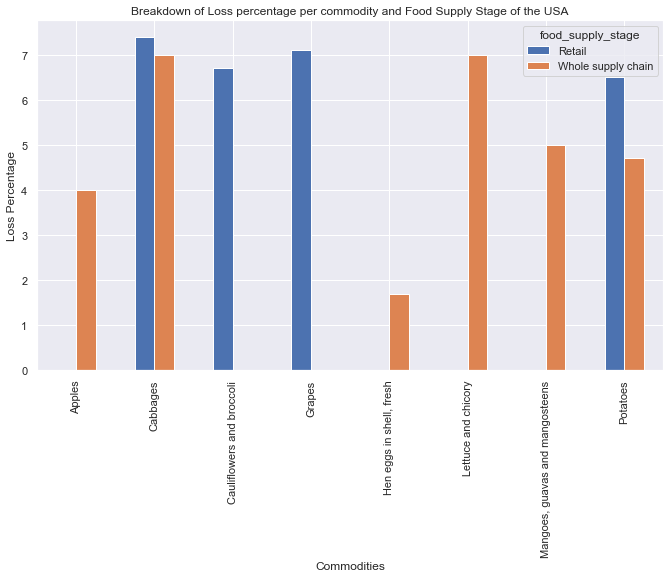

In [15]:
# Showing the  point estimate of the loss percentage in USA (country with highest loss)
usdf=df.loc[df['country'] == "United States of America"]

result = usdf.groupby(["food_supply_stage","commodity"])['loss_percentage'].aggregate(np.mean).reset_index().sort_values('loss_percentage',   
                                                                                                 ascending =False)

df_pivot = pd.pivot_table(result,values="loss_percentage",index="commodity",columns="food_supply_stage")

# Plot a bar chart using the DF
ax = df_pivot.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(10, 6)
# Change the axes labels
ax.set_xlabel("Commodities")
ax.set_ylabel("Loss Percentage")
ax.set_title("Breakdown of Loss percentage per commodity and Food Supply Stage of the USA")


Text(0.5, 1.0, 'Breakdown of Loss percentage per commodity of the USA')

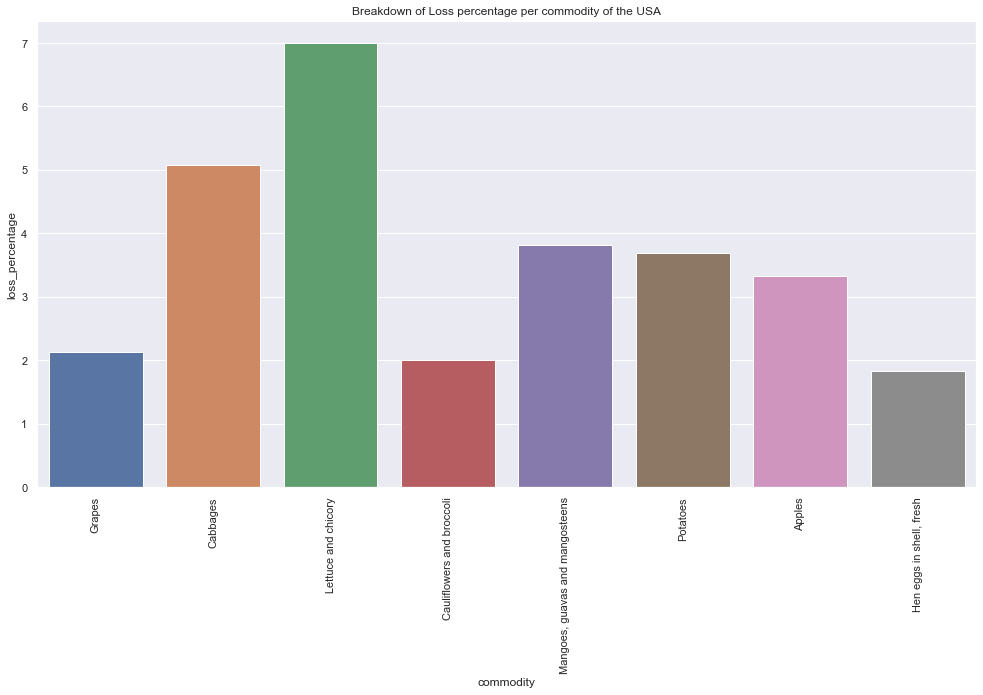

In [16]:

result1 = usdf.groupby(["commodity"])['loss_percentage'].aggregate(np.mean).reset_index().sort_values('loss_percentage',   
                                                                                               ascending =False)
ax = sns.barplot(x="commodity", y="loss_percentage", data= df, order=result1["commodity"], ci =None)
plt.xticks(rotation='vertical')
ax.set_title("Breakdown of Loss percentage per commodity of the USA")


Text(0.5, 1.0, 'Breakdown of Loss percentage per Food Supply Stage of the USA')

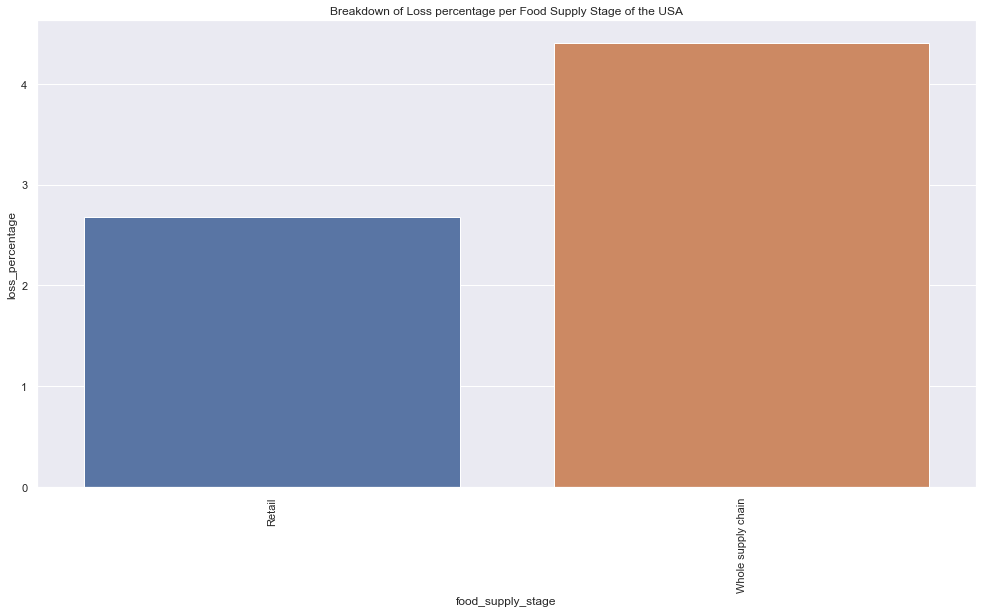

In [17]:

result1 = usdf.groupby(["food_supply_stage"])['loss_percentage'].aggregate(np.mean).reset_index().sort_values('loss_percentage',   
                                                                                                   ascending =False)
ax = sns.barplot(x="food_supply_stage", y="loss_percentage", data= df, order=result1["food_supply_stage"], ci =None)
plt.xticks(rotation='vertical')
ax.set_title("Breakdown of Loss percentage per Food Supply Stage of the USA")


#### Data Cleaning
Remove rows with missing values

In [18]:
# print how many missing values on each column
print("Before removing rows with missing values")
print(df.isna().sum())
print(df.shape)
print()

# remove the rows with missing values
df = df.dropna()

# print again how many missing values on each column
print("After removing rows with missing values")
print(df.isna().sum())
print(df.shape)


Before removing rows with missing values
year                 0
country              0
commodity            0
food_supply_stage    8
loss_percentage      0
dtype: int64
(19021, 5)

After removing rows with missing values
year                 0
country              0
commodity            0
food_supply_stage    0
loss_percentage      0
dtype: int64
(19013, 5)


#### Data Transformation
- Encoding
- Scaling

##### Encoding
One-hot encoding is used for the food_supply_stage and commodity while label encoding is used for country

In [19]:
# get all categorical and numerical columns
data_column_category = df.select_dtypes(exclude=[np.number]).columns
data_column_number = df.select_dtypes(include=[np.number]).columns

In [20]:
# perform label encoding
label_encode_columns = [ "country"]
label_encoder = LabelEncoder()
df_before_encoding = df.copy()

for i in data_column_category:
    df.loc[:,i] = label_encoder.fit_transform(df[i])

df.head()

,year,country,commodity,food_supply_stage,loss_percentage
13,2020,6,18,2,3.50
14,2020,6,18,2,4.87
15,2020,6,18,2,2.50
16,2020,6,18,4,4.43
17,2020,6,8,2,4.00


In [21]:
# perform one-hot encoding
onehot_encode_columns = ["food_supply_stage", "commodity"]
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(df[onehot_encode_columns])
onehot_encoded_frame = pd.DataFrame(onehot_encoded, columns = onehot_encoder.get_feature_names(onehot_encode_columns))
df_onehot_getdummies = pd.get_dummies(df_before_encoding[onehot_encode_columns], prefix=onehot_encode_columns)
data_onehot_encoded_data = pd.concat([df[label_encode_columns], df_before_encoding[data_column_number], df_onehot_getdummies],axis = 1)
df = data_onehot_encoded_data
df.head()

,country,year,loss_percentage,food_supply_stage_Distribution,food_supply_stage_Export,food_supply_stage_Farm,food_supply_stage_Food Services,food_supply_stage_Harvest,food_supply_stage_Households,food_supply_stage_Market,...,"commodity_Mangoes, guavas and mangosteens",commodity_Millet,commodity_Oats,commodity_Potatoes,commodity_Raw milk of cattle,commodity_Rice,commodity_Rye,commodity_Sorghum,commodity_Tomatoes,commodity_Wheat
13,6,2020,3.50,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14,6,2020,4.87,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15,6,2020,2.50,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16,6,2020,4.43,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
17,6,2020,4.00,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Scaling
MinMaxScaler method will be used

In [22]:
# perform min-max scaler
scaler = MinMaxScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()

,country,year,loss_percentage,food_supply_stage_Distribution,food_supply_stage_Export,food_supply_stage_Farm,food_supply_stage_Food Services,food_supply_stage_Harvest,food_supply_stage_Households,food_supply_stage_Market,...,"commodity_Mangoes, guavas and mangosteens",commodity_Millet,commodity_Oats,commodity_Potatoes,commodity_Raw milk of cattle,commodity_Rice,commodity_Rye,commodity_Sorghum,commodity_Tomatoes,commodity_Wheat
0,0.157895,1.0,0.456209,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.157895,1.0,0.635294,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.157895,1.0,0.325490,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.157895,1.0,0.577778,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.157895,1.0,0.521569,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Show the preprocessed Dataset

In [23]:
# print the column names
print('---PREPROCESSED DATASET---\n')
print('COLUMNS')
print(df.columns)
print()

# print the shape
print('SHAPE')
print(df.shape)

# show the first 5 rows of the dataframe
df.head()

---PREPROCESSED DATASET---

COLUMNS
Index(['country', 'year', 'loss_percentage', 'food_supply_stage_Distribution',
       'food_supply_stage_Export', 'food_supply_stage_Farm',
       'food_supply_stage_Food Services', 'food_supply_stage_Harvest',
       'food_supply_stage_Households', 'food_supply_stage_Market',
       'food_supply_stage_Post-harvest', 'food_supply_stage_Processing',
       'food_supply_stage_Retail', 'food_supply_stage_Storage',
       'food_supply_stage_Trader', 'food_supply_stage_Transport',
       'food_supply_stage_Whole supply chain', 'food_supply_stage_Wholesale',
       'commodity_Apples', 'commodity_Barley', 'commodity_Cabbages',
       'commodity_Cauliflowers and broccoli', 'commodity_Fonio',
       'commodity_Grapes', 'commodity_Hen eggs in shell, fresh',
       'commodity_Lettuce and chicory', 'commodity_Maize (corn)',
       'commodity_Mangoes, guavas and mangosteens', 'commodity_Millet',
       'commodity_Oats', 'commodity_Potatoes', 'commodity_Raw milk o

,country,year,loss_percentage,food_supply_stage_Distribution,food_supply_stage_Export,food_supply_stage_Farm,food_supply_stage_Food Services,food_supply_stage_Harvest,food_supply_stage_Households,food_supply_stage_Market,...,"commodity_Mangoes, guavas and mangosteens",commodity_Millet,commodity_Oats,commodity_Potatoes,commodity_Raw milk of cattle,commodity_Rice,commodity_Rye,commodity_Sorghum,commodity_Tomatoes,commodity_Wheat
0,0.157895,1.0,0.456209,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.157895,1.0,0.635294,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.157895,1.0,0.325490,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.157895,1.0,0.577778,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.157895,1.0,0.521569,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that all the variables have been transformed to numerical columns, let us check their relationships using a heatmap.

<AxesSubplot:>

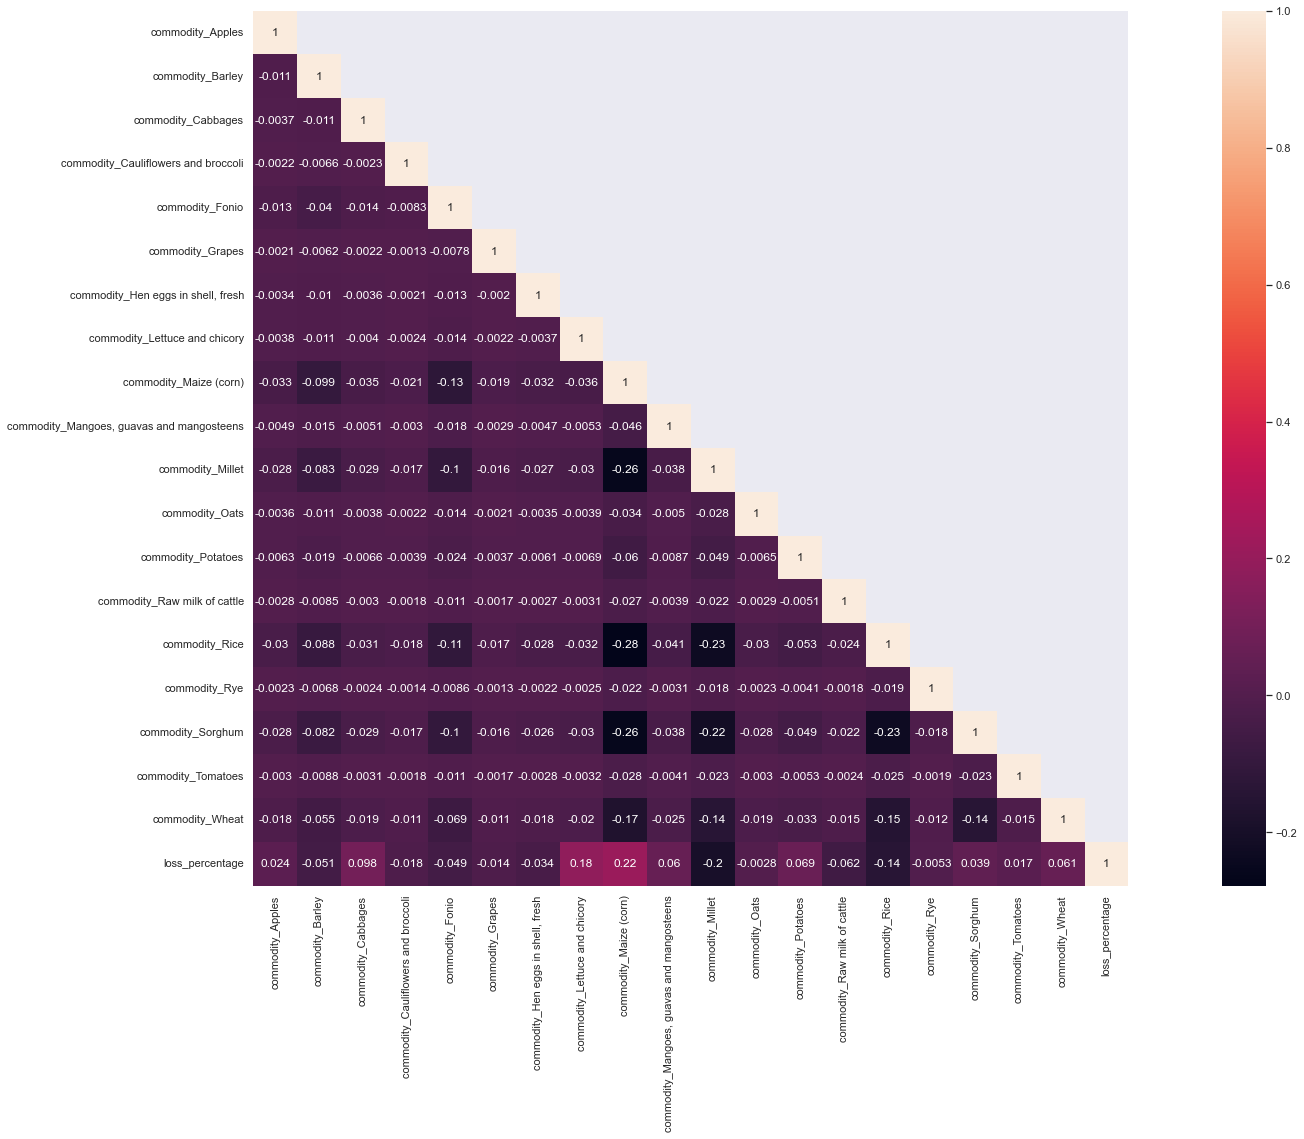

In [24]:
#corelation matrix of loss percentage to commodities

cor_mat= df[df.columns[df.columns.str.contains('commodity')].union(
    df.columns[df.columns.str.contains('loss_percentage')]) ].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,15)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

#### Inferences from the heatmap
- loss_percentage shows positive relation to the commodities Tomatoes, Cabbages, (Mangoes, guavas, and mangosteens), (lettuce and chicory),wheat, apples, maize/corn, potatoes, and sorghum. 
- loss_percentage shows negative relation to the other commodities not mentioned.

<AxesSubplot:>

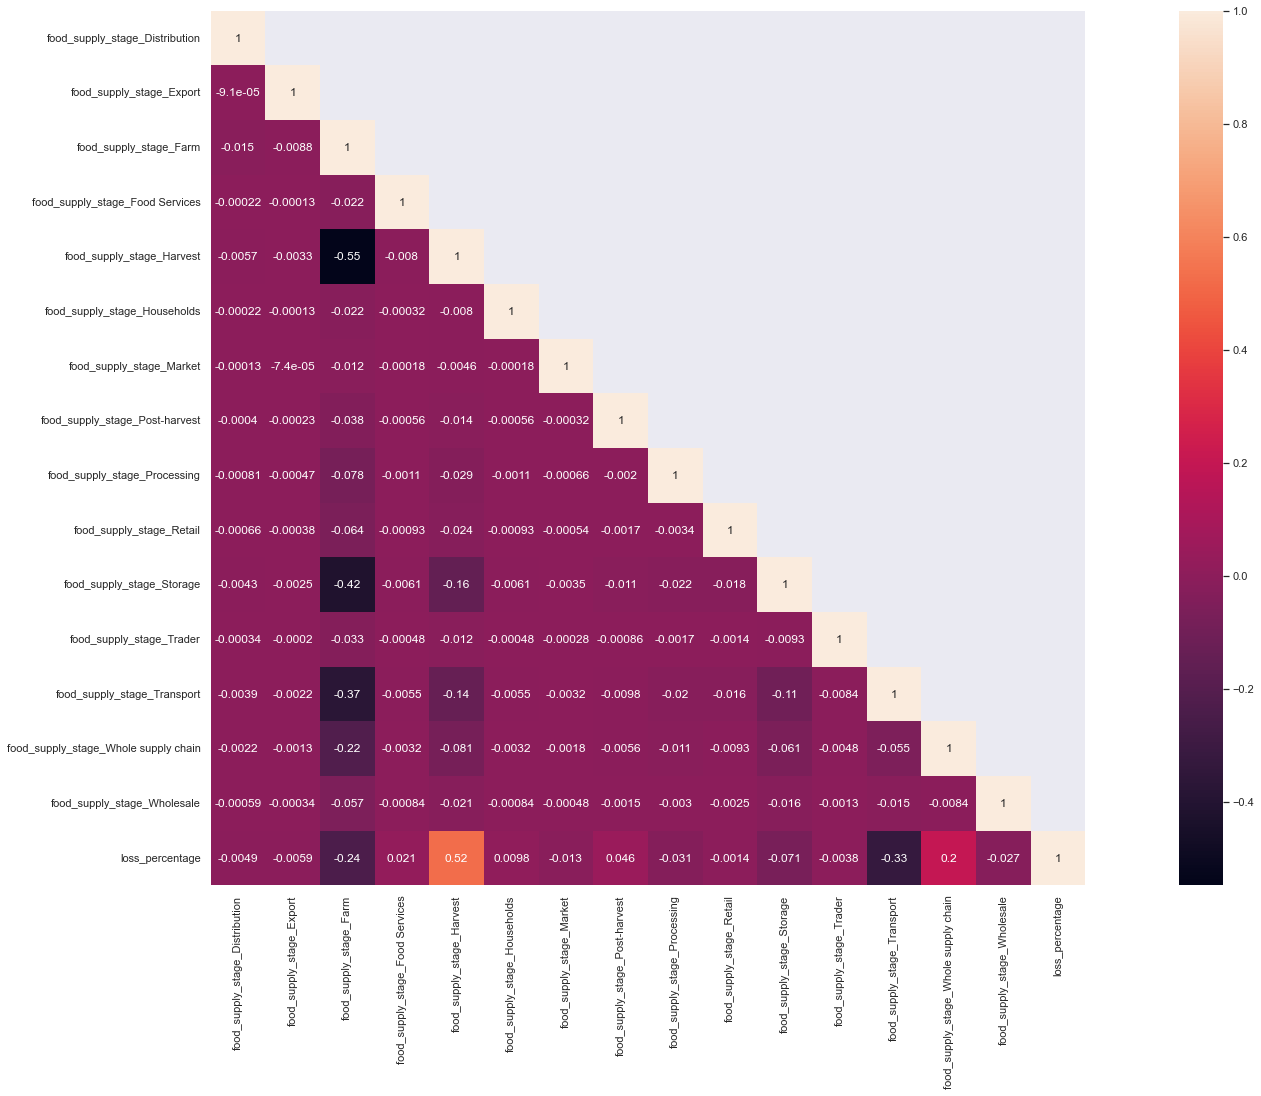

In [25]:
#corelation matrix of food supply stage to loss percentage

cor_mat= df[df.columns[df.columns.str.contains('food_supply_stage')].union(
    df.columns[df.columns.str.contains('loss_percentage')]) ].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,15)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

#### Inferences from the heatmap
- loss_percentage shows strong positive relation on whole supply chain, and harvest

<AxesSubplot:>

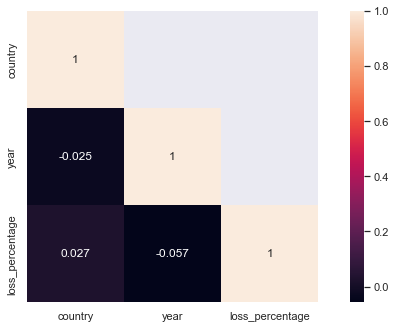

In [26]:
#corelation matrix of country and year to loss percentage
cor_mat= df.filter(['country', 'year', 'loss_percentage']).corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(10,5)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

#### Inferences from the heatmap
- loss_percentage shows positive relation to country (albeit small) but shows negative relation to year

#### Creating Train and Test Data
The dataset for each FSC stage will be divided into 80:20 ratio for training and testing data

In [27]:
# Remove spcial JSON characters (required when using LightGBM)
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# store all feature columns in 'X' and the target feature in 'y'
X = df.drop('loss_percentage', axis=1)
y = df['loss_percentage']

# split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("X_train : ",X_train.shape)
print("X_test : ",X_test.shape)
print("y_train : ",y_train.shape)
print("y_test : ",y_test.shape)
# Remove spcial JSON characters (required when using LightGBM)
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# store all feature columns in 'X' and the target feature in 'y'
X = df.drop('loss_percentage', axis=1)
y = df['loss_percentage']

# split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("X_train : ",X_train.shape)
print("X_test : ",X_test.shape)
print("y_train : ",y_train.shape)
print("y_test : ",y_test.shape)

X_train :  (15210, 36)
X_test :  (3803, 36)
y_train :  (15210,)
y_test :  (3803,)
X_train :  (15210, 36)
X_test :  (3803, 36)
y_train :  (15210,)
y_test :  (3803,)


## Modelling

### Regression Evaluation Metrics

- The lower value of MAE, MSE, and RMSE implies higher accuracy of a regression model. However, a higher value of R square is considered desirable.

In [28]:
model_results = {}

def plot_model_accuracy(pred, model_name):
    # Visualizing Regression Model
    plt.ylim(0, 1)
    plt.title("Loss Percentage Comparison for {model_name}".format(model_name = model_name))
    ax = sns.regplot(x=y_test, y=pred);
    ax.set_xlabel( "Actual")
    ax.set_ylabel( "Prediction")

def evaluate(model, model_name):
    print("EVALUATING {model_name}\n".format(model_name = model_name.upper()))
    
    # transforming target variable through quantile transformer
    regr_trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
    regr_trans.fit(X_train, y_train)
    pred = regr_trans.predict(X_test)
    
    # computing for metrics
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2_square = r2_score(y_test, pred)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R-Square:', r2_square)
    
    model_results[model_name] = [mae, mse, rmse, r2_square]
    plot_model_accuracy(pred, model_name)
    


### Linear Regression

EVALUATING LINEAR REGRESSION

MAE: 0.09989303649585395
MSE: 0.0182030319617922
RMSE: 0.13491861236238756
R-Square: 0.5201791786601047


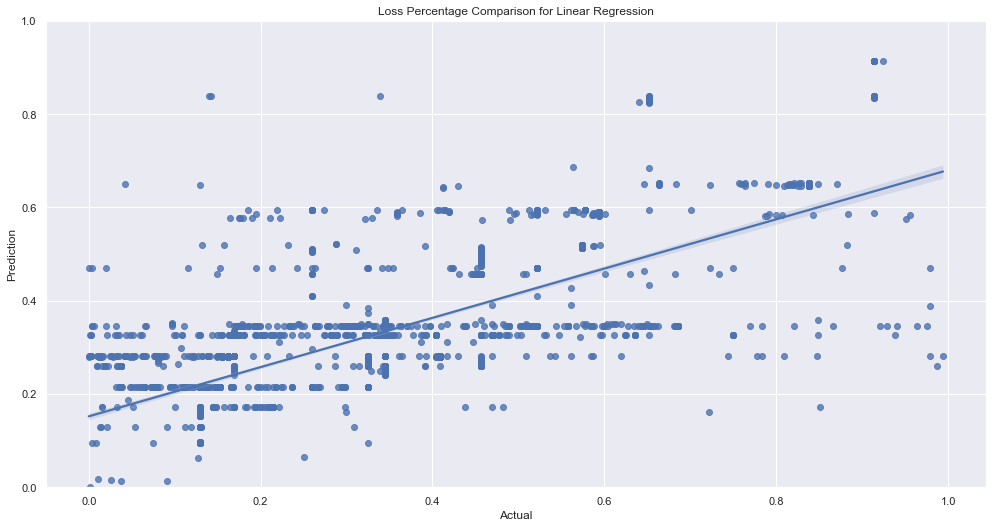

In [29]:
model = LinearRegression()
evaluate(model, "Linear Regression")

### Lasso Regression

EVALUATING LASSO REGRESSION

MAE: 0.10327720007238629
MSE: 0.01986474004587322
RMSE: 0.14094232879399013
R-Square: 0.4763775669613248


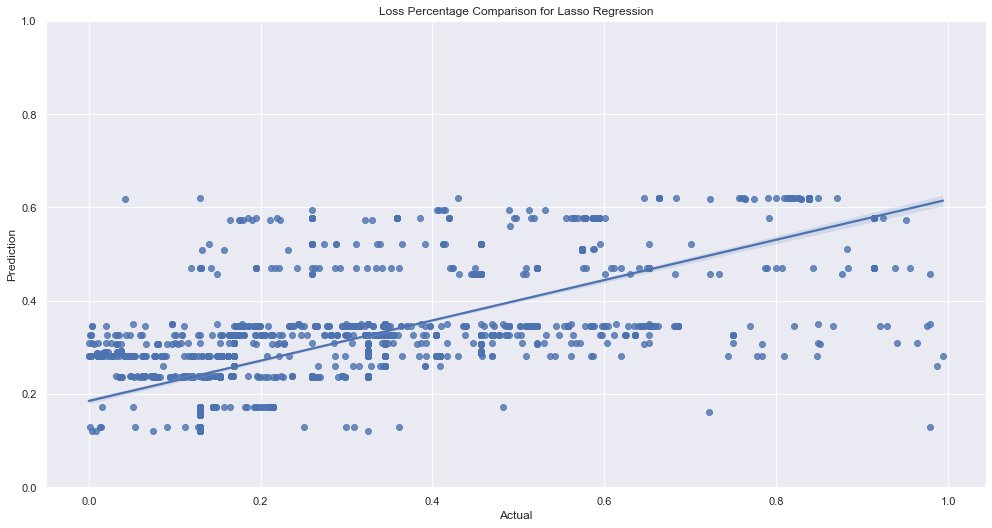

In [30]:
model = Lasso(alpha = 0.005, max_iter = 100, tol =0.001)
evaluate(model, "Lasso Regression")

### Ridge Regression

EVALUATING RIDGE REGRESSION

MAE: 0.0996230894255494
MSE: 0.018077747047320927
RMSE: 0.13445351258825827
R-Square: 0.5234816126001913


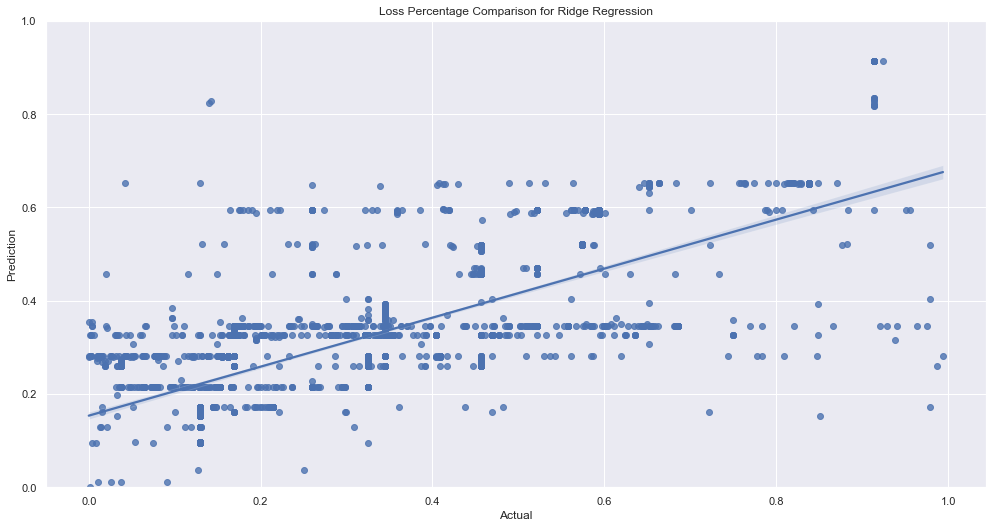

In [31]:
model = Ridge(alpha = 0.005, max_iter = 100, tol =0.001)
evaluate(model, "Ridge Regression")

### Decision Tree Regressor

EVALUATING DECISION TREE REGRESSOR

MAE: 0.10175667855594465
MSE: 0.02365789394082763
RMSE: 0.15381122826642935
R-Square: 0.3763923435564621


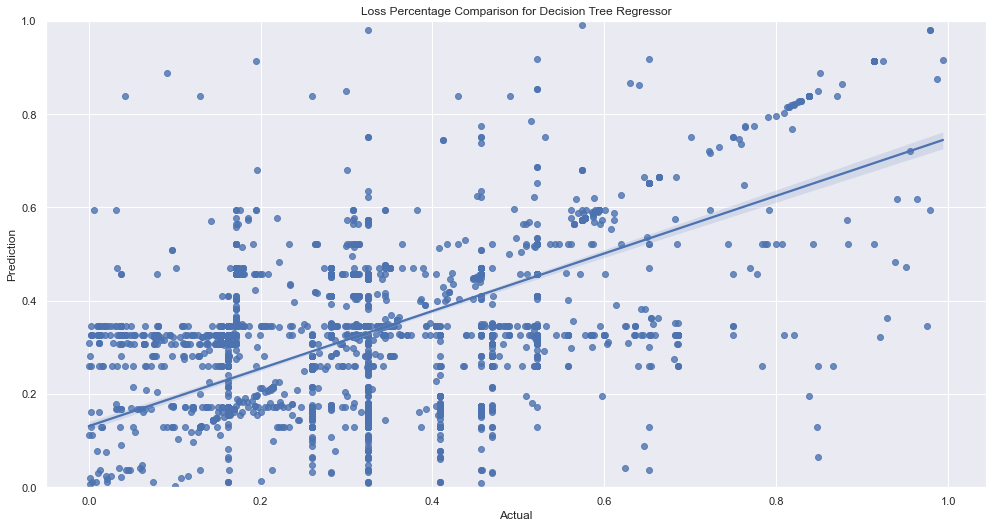

In [32]:
model = DecisionTreeRegressor()
evaluate(model, "Decision Tree Regressor")

### Random Forest Regressor

EVALUATING RANDOM FOREST REGRESSOR

MAE: 0.09665065577876553
MSE: 0.02070670779602053
RMSE: 0.1438982550138136
R-Square: 0.4541838105439675


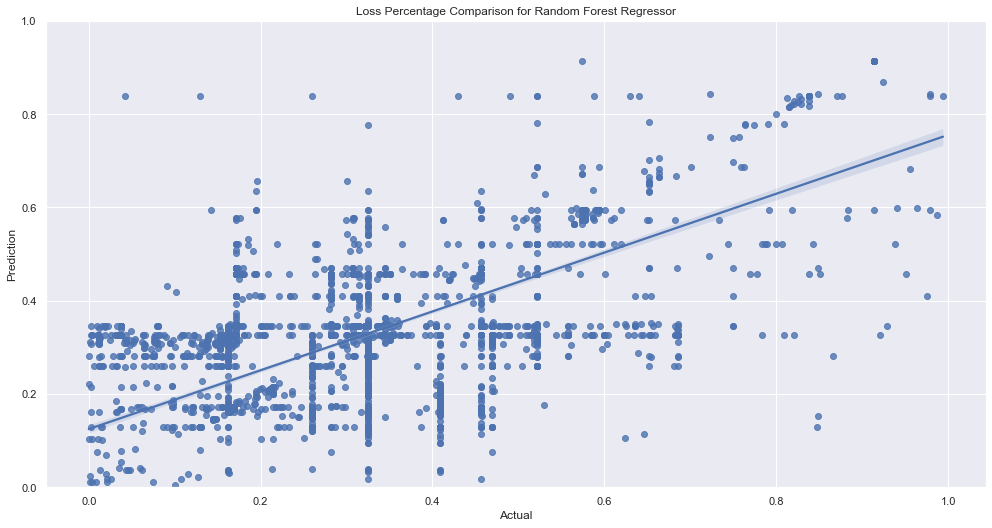

In [33]:
model = RandomForestRegressor()
evaluate(model, "Random Forest Regressor")

### Gradient Boosting Regressor

EVALUATING GRADIENT BOOSTING REGRESSOR

MAE: 0.0881369514243274
MSE: 0.015618462562938794
RMSE: 0.1249738475159455
R-Square: 0.5883068518065787


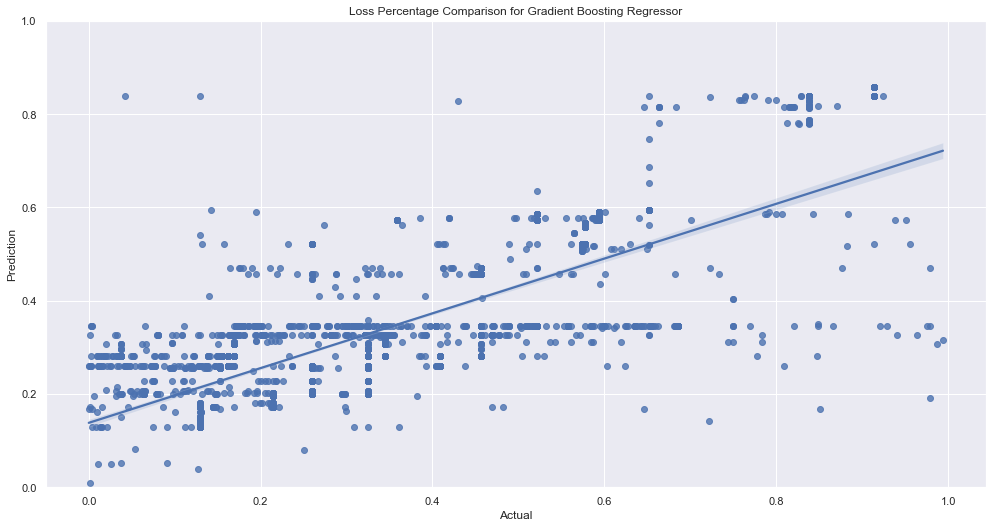

In [34]:
model = GradientBoostingRegressor()
evaluate(model, "Gradient Boosting Regressor")

### LightGBM Regressor

EVALUATING LIGHTGBM REGRESSOR

MAE: 0.07855833166122138
MSE: 0.013473048687248027
RMSE: 0.11607346245911693
R-Square: 0.644858653182782


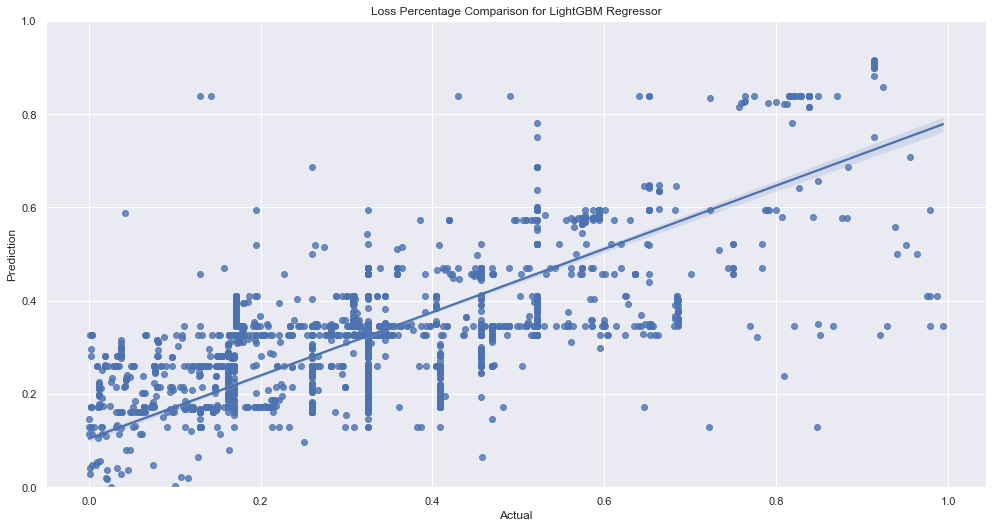

In [35]:
model = lightgbm.LGBMRegressor()
evaluate(model, "LightGBM Regressor")

### XGBoost Regressor

EVALUATING XGBOOST REGRESSOR

MAE: 0.08689223481796494
MSE: 0.015924429372448534
RMSE: 0.126192033712309
R-Square: 0.5802417533026668


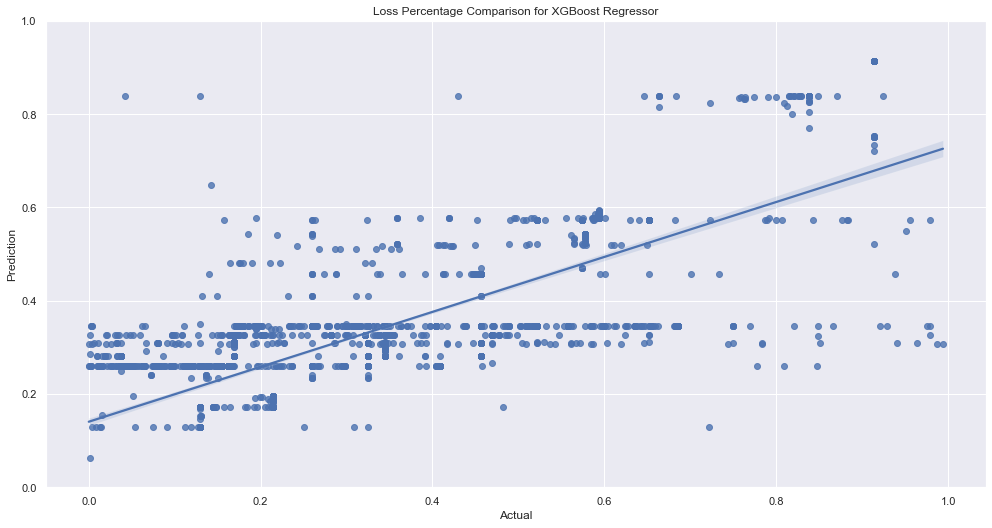

In [36]:
model = xgboost.XGBRFRegressor()
evaluate(model, "XGBoost Regressor")

### Models Comparison

In [37]:
model_results_list = [[key] + model_results[key] for key in model_results]

results_df = pd.DataFrame(model_results_list, columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])
results_df.set_index('Model', inplace=True)
results_df

,MAE,MSE,RMSE,R2
Model,,,,
Linear Regression,0.099893,0.018203,0.134919,0.520179
Lasso Regression,0.103277,0.019865,0.140942,0.476378
Ridge Regression,0.099623,0.018078,0.134454,0.523482
Decision Tree Regressor,0.101757,0.023658,0.153811,0.376392
Random Forest Regressor,0.096651,0.020707,0.143898,0.454184
Gradient Boosting Regressor,0.088137,0.015618,0.124974,0.588307
LightGBM Regressor,0.078558,0.013473,0.116073,0.644859
XGBoost Regressor,0.086892,0.015924,0.126192,0.580242


<AxesSubplot:ylabel='Model'>

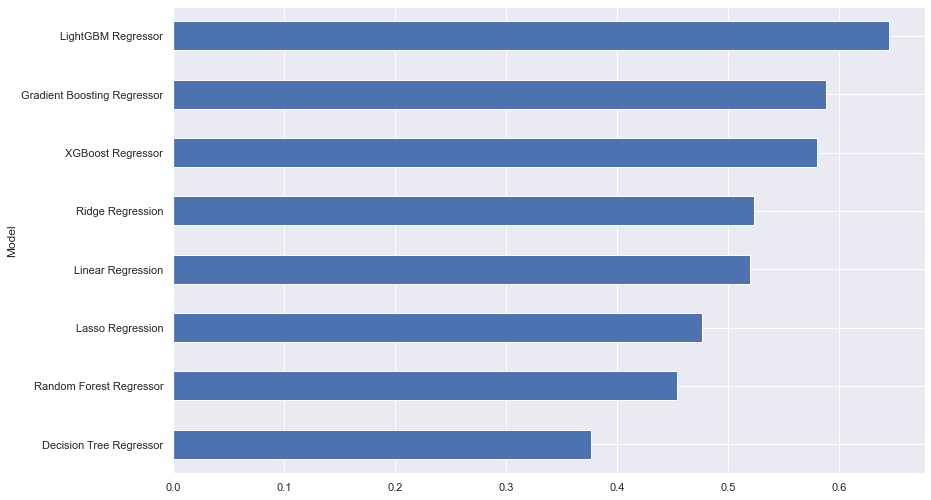

In [38]:
# Visualize R2
results_df['R2'].sort_values().plot(kind='barh', figsize=(12, 8))

We can infer from the graph that `LightGBM Regressor` is the best model for the data.

### Tuning Hyperparameters for LightGBM Regressor

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 0.25}
EVALUATING LIGHTGBM REGRESSOR TUNED HYPERPARAMETER

MAE: 0.0800685967008135
MSE: 0.013831269638092928
RMSE: 0.11760641835415671
R-Square: 0.635416167380618


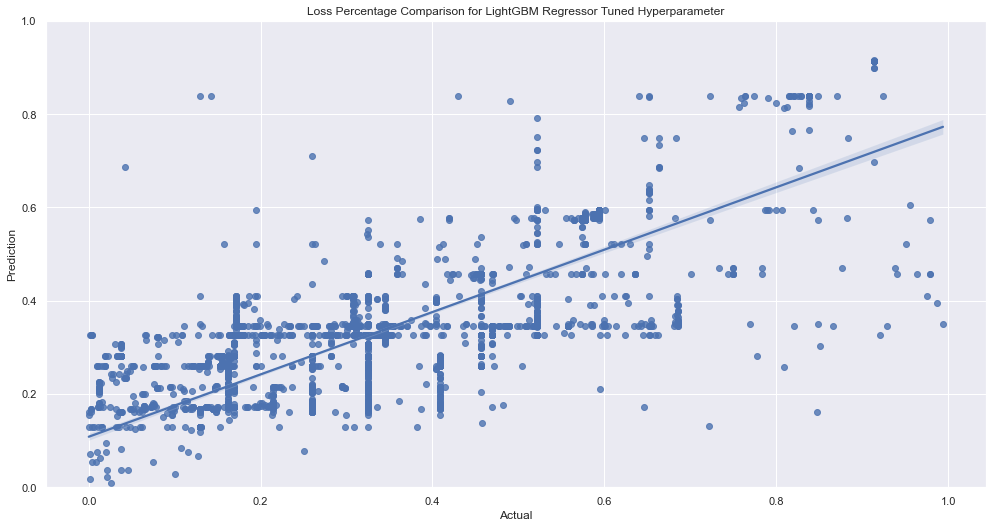

In [39]:
model = lightgbm.LGBMRegressor()

param_grid = {'n_estimators': [100, 80, 60, 55, 51, 45],  
              'max_depth': [7, 8],
              'reg_lambda' :[0.26, 0.25, 0.2]
             }

grid = GridSearchCV(model, param_grid, refit = True, verbose = 3, n_jobs=-1)
regr_trans = TransformedTargetRegressor(regressor=grid, transformer=QuantileTransformer(output_distribution='normal'))

# fitting the model for grid search 
grid_result = regr_trans.fit(X_train, y_train)
best_params = grid_result.regressor_.best_params_
print(best_params)

#using best params to create and fit model
best_model = lightgbm.LGBMRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], reg_lambda=best_params["reg_lambda"])
evaluate(best_model, "LightGBM Regressor Tuned Hyperparameter")